# The Battle of the neighborhoods

## Table of contents
* [Introduction Section](#introduction)
* [Data Section](#data)
* [Methodology Section](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Import Libraries Required

In [125]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe


# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import folium # map rendering library
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

from sklearn.preprocessing import StandardScaler
# import k-means from clustering stage
from sklearn.cluster import KMeans



print('Libraries imported.')

Libraries imported.


## 1. Introduction Section :<a name="introduction"></a>

### Discussion of the business problem and the audience who would be interested in this project.

### 1.1 Scenario and backgroud

 I am a data scientist living in Shanghai. I have rent an apartment unit in Qingpu Area. However, after several months, I find it is very inconvenient as the apartment is far from subway station and there is no large supermarket within 3 kilometers. Furthermore, recently I was offered a new job in another area(Yangpu Area). So I would like to buy a new apartment which brings more convenience to my work and life.

### 1.2 Problem to be resolved:

The challenge to resolve is being able to find a second-hand apartment in Yangpu Area that is subject to the following conditions:

1. Apartment with min 2 bedrooms and min 80 square meters with price not to exceed 6,000,000RMB
2. Area with ammenities like subway metro station,supermarket and cinemas within walking distance(<=1.5 km)

### 1.3 Interested Audience

I believe this is a relevant project for a person who wants to find a better place to live and work, since the approach and methodologies used here are applicable in all cases. The use of FourSquare data, scraping other relevant data from website and mapping techniques combined with data analysis will help resolve the key questions arisen. Lastly, this project is a good practical case toward the development of Data Science skills.

## 2.Data Section:<a name="data"></a>

### 2.1 Data Required to resolve the problem

In order to make a good choice of a good apartment in Shanghai, the following data is required:

1. Listed second-hand apartments in Yangpu Area with descriptions (price, location, how many bedrooms,area)
2. Geodata (latitude, longitude) of the second-hand apartments
3. Venues and ammenities in the neighborhoods

### 2.2 Data source

#### 1. Scrap second-hand apartment info from a website named Lianjia and transform data into dataframe
https://sh.lianjia.com/ershoufang/yangpu/rp5/

In [2]:
df_house=pd.read_csv('lianjia.csv',header=None)
df_house.head()

0      1  2       3
0   松花江路95弄      238.0  1   49.08
1      民星一村      157.0  1   42.40
2     宝地东花园      890.0  2  105.81
3  控江路1455弄      315.0  2   55.85
4   眉州路515弄      218.0  1   35.11

In [3]:
df_house.columns=['Address','Price','Bedrooms','Area']

In [4]:
df_house['Address']=df_house['Address'].str.strip()

In [5]:
df_house.dtypes

Address      object
Price       float64
Bedrooms      int64
Area        float64
dtype: object

##### After droping duplicates, 2959 records left. 

In [6]:
df_house.shape[0]

3000

In [7]:
df_house.drop_duplicates(inplace=True)

In [8]:
df_house.shape[0]

2959

##### select appartment satisfying the first condition in section 1.2 

350 apartments are selected

In [27]:
df_selected=df_house[(df_house.Price<=600)&(df_house.Bedrooms>=2)&(df_house.Area>=80)]
df_selected.shape 

(201, 4)

In [28]:
df_selected.head(10)

Address  Price  Bedrooms    Area
8        阳明新城  558.0         3   89.79
37       松花公寓  428.0         2   83.00
46       文化名园  570.0         3   92.70
57   鞍山四村第二小区  550.0         2   87.90
96       东田公寓  555.0         2  104.52
116     宝钢又一村  545.0         2   85.40
121      海鸿公寓  550.0         3   98.50
132      申通公寓  500.0         2   83.74
140       韵都城  600.0         2   80.71
154      市光一村  450.0         2   83.36

Extract addresses of these selected appartments

In [29]:
address_list=df_selected.Address.unique().tolist()

In [30]:
len(address_list)

116

#### 2. Get geodata of the addresses of selected apartments with Baidu api

In [43]:
df_geo=pd.read_csv('apartment_geocode.csv')
df_geo.shape

(116, 3)

In [44]:
df_geo.head()

Address   Longitude   Latitude
0      阳明新城  121.527805  31.275399
1      松花公寓  121.545267  31.300812
2      文化名园  121.498061  31.312913
3  鞍山四村第二小区  121.514984  31.283729
4      东田公寓  121.535937  31.276374

In [45]:
df_geo.tail()

Address   Longitude   Latitude
111     海鹏苑  121.553896  31.284424
112    梅林公寓  121.561740  31.292721
113    联升大厦  121.542027  31.269038
114    辽源一村  121.516130  31.276325
115  国威大厦小区  121.545551  31.280040

#### 3. Use Foursquare data and geodata to map venues

In this part, I will use foursquare api to check venues around the selected apartment to see if it is convenient enough.

Foursquare credentials are defined in hidden cell bellow.

# 要改！！！

In [16]:
# The code was removed by Watson Studio for sharing.

In [49]:
# Define the radius and venue list
venue_list=['metro station','超市','电影院']
radius = 1500

In [63]:
count=0
for i in range(103,df_geo.shape[0]):
    longitude=df_geo.iloc[i,1]
    latitude=df_geo.iloc[i,2] 
    for venue in venue_list:
        search_query=venue
        # Define the corresponding URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
        # Send the GET Request and examine the results
        results = requests.get(url).json()
        # assign relevant part of JSON to venues
        venues_response = results['response']['venues']
        venue_num=len(venues_response)
        df_geo.loc[i,venue]=venue_num
#         print(time.time())
    count+=1
    if count==8:
        count=0
        time.sleep(30)


In [64]:
df_geo.tail(5)

Address   Longitude   Latitude  metro station   超市  电影院
111     海鹏苑  121.553896  31.284424            3.0  3.0  3.0
112    梅林公寓  121.561740  31.292721            2.0  1.0  0.0
113    联升大厦  121.542027  31.269038            4.0  4.0  5.0
114    辽源一村  121.516130  31.276325            9.0  6.0  4.0
115  国威大厦小区  121.545551  31.280040            4.0  5.0  4.0

In [65]:
df_geo.to_csv('geodata_with_venues.csv',index=False)

#### 4. Merge selected apartments info with their geodata

In [66]:
df_app=pd.merge(df_selected,df_geo,on='Address')
df_app.head()

Address  Price  Bedrooms   Area   Longitude   Latitude  metro station   超市  \
0    阳明新城  558.0         3  89.79  121.527805  31.275399            7.0  7.0   
1    阳明新城  575.0         3  89.79  121.527805  31.275399            7.0  7.0   
2    阳明新城  568.0         3  89.79  121.527805  31.275399            7.0  7.0   
3    松花公寓  428.0         2  83.00  121.545267  31.300812            2.0  3.0   
4    松花公寓  440.0         2  82.23  121.545267  31.300812            2.0  3.0   

   电影院  
0  5.0  
1  5.0  
2  5.0  
3  0.0  
4  0.0

In [108]:
df_app.rename(columns={'超市':'Supermarket','电影院':'Cinema'},inplace=True)

In [261]:
df_app.iloc[:,6:9]=df_app.iloc[:,6:9].astype('int')

In [277]:
df_app.tail()

Address  Price  Bedrooms    Area   Longitude   Latitude  metro station  \
196     海鹏苑  560.0         2   94.00  121.553896  31.284424              3   
197    梅林公寓  560.0         3   93.00  121.561740  31.292721              2   
198    联升大厦  600.0         3  118.18  121.542027  31.269038              4   
199    辽源一村  580.0         3   88.36  121.516130  31.276325              9   
200  国威大厦小区  590.0         2   98.86  121.545551  31.280040              4   

     Supermarket  Cinema  Price/m^2  
196            3       3   5.957447  
197            1       0   6.021505  
198            4       5   5.077001  
199            6       4   6.564056  
200            5       4   5.968036

In [278]:
df_app.shape[0]

201

#### 5. Select appartment satisfying the second condition in section 1.2 

In [279]:
df_conv_app=df_app[(df_app.Cinema!=0)&(df_app['metro station']!=0)&(df_app.Supermarket!=0)]
df_conv_app.shape[0]

137

In [280]:
df_conv_app.reset_index(drop=True,inplace=True)

In [319]:
df_conv_app.head()

Address  Price  Bedrooms   Area   Longitude   Latitude  metro station  \
0      阳明新城  558.0         3  89.79  121.527805  31.275399              7   
1      阳明新城  575.0         3  89.79  121.527805  31.275399              7   
2      阳明新城  568.0         3  89.79  121.527805  31.275399              7   
3      文化名园  570.0         3  92.70  121.498061  31.312913              6   
4  鞍山四村第二小区  550.0         2  87.90  121.514984  31.283729             10   

   Supermarket  Cinema  Price/m^2  Cluster  
0            7       5   6.214501        2  
1            7       5   6.403831        1  
2            7       5   6.325871        1  
3            9       5   6.148867        1  
4            6       7   6.257110        1

## 3. Methodology Section:<a name="methodology"></a>

In this project we will direct our efforts on choosing an appropriate apartment in Shanghai Yangpu Area. The apartment meet requirements in the Introduction Section

In first step we have collected the required **data: price,number of bedrooms,area,location and venues** .

Second step we will explore the information of apartment, such as price, number of bedrooms and area to see if my constraint is a common requirement. In this part, we will also figure out the relationship between price and area.We will compare the situation of all apartments in Yangpu Area and the selected convenient apartments. 

In third and final step we will locate selected convenient apartments in the map and we will use k-means clustering method to divide them into 3 categories by price, area, location. After that we will find features of each cluster. Finally, we will try to find if there's a **cost efficient** apartment.

## 4. Results and Discussion:<a name="results"></a>

### For all apartments in the area:

Here are the findings of all apartments: 
1. the median is around 3,000,000RMB, 3 quarters are less than 7,500,000RMB;
2. Price of apartment with 1,2,3 rooms differs obviously while price of apartment with 4,5,6,7 rooms differs slightly. One interesting finding is that appartments with 6 rooms are a litte cheaper than those with 5 rooms;
3. price, bedrooms and area are highly correlated;
4. the most frequent price/m^2 is 60,000 RMB/m^2;
5. no correlation between unit price and area.


From the histogram, we can find that a long tail exists in the diagram.

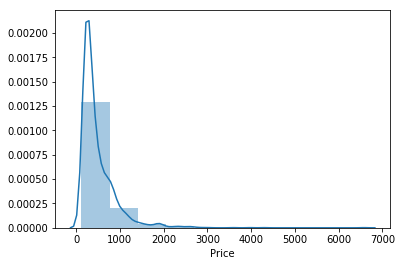

In [95]:
sns.distplot(df_house['Price'],bins=10)

To see the price in more detail, we plot the box graph of price and find the median is around 3,000,000RMB, 3 quarters are less than 7,500,000RMB.

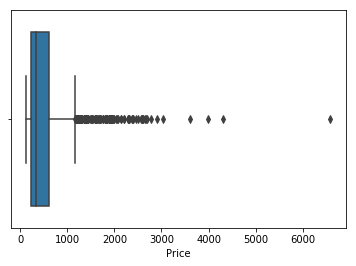

In [97]:
sns.boxplot(df_house['Price'])

We find price, bedrooms and area are highly correlated.

In [79]:
df_house.corr()

Price  Bedrooms      Area
Price     1.000000  0.788027  0.958958
Bedrooms  0.788027  1.000000  0.822167
Area      0.958958  0.822167  1.000000

Price of apartment with 1,2,3 rooms differs obviously while price of apartment with 4,5,6,7 rooms differs slightly. One interesting finding is that appartments with 6 rooms are a litte cheaper than those with 5 rooms.

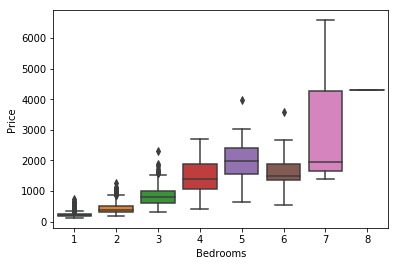

In [80]:
sns.boxplot(x='Bedrooms', y= 'Price', data=df_house)

Price and area are positively related.

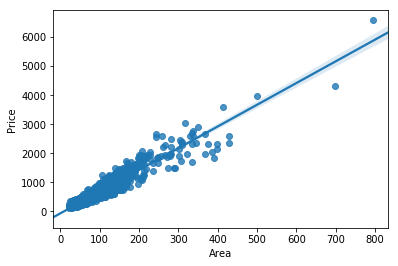

In [81]:
sns.regplot(x='Area', y= 'Price', data=df_house)

Let's see the distribution of price per square meter.

In [85]:
df_house['Price/m^2']=df_house.Price/df_house.Area

The median price/m^2 is 60,000 RMB/m^2.

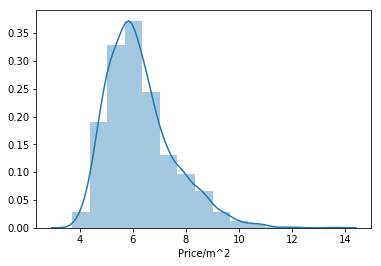

In [89]:
sns.distplot(df_house['Price/m^2'],bins=15)

No correlation between unit price and area.

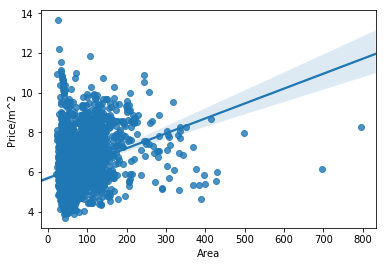

In [90]:
sns.regplot(x='Area', y= 'Price/m^2', data=df_house)

In [93]:
df_house.corr()

Price  Bedrooms      Area  Price/m^2
Price      1.000000  0.788027  0.958958   0.516376
Bedrooms   0.788027  1.000000  0.822167   0.295747
Area       0.958958  0.822167  1.000000   0.314029
Price/m^2  0.516376  0.295747  0.314029   1.000000

### For selected convenient apartments:

Here are the findings of selected convenient apartments: 
1. most apartments are around 5,800,000RMB;
2. almost no difference between price of apartments with different rooms;
3. price and area are slightly correlated;
4. the most frequent price/m^2 is 60,000 RMB/m^2;
5. no correlation between unit price and area.
6. as for tranportation, most apartments have 4 metro stations within working distance;
7. as for shopping, most apartments have 4 supermarkets within working distance;
8. as for entertainment, most apartments have 6 cinema within working distance.

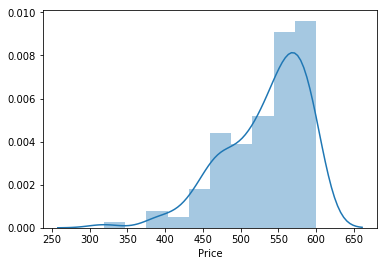

In [254]:
sns.distplot(df_conv_app['Price'],bins=10)

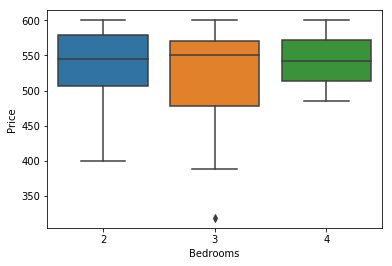

In [255]:
sns.boxplot(x='Bedrooms', y= 'Price', data=df_conv_app)

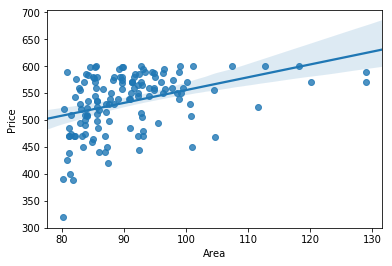

In [256]:
sns.regplot(x='Area', y= 'Price', data=df_conv_app)

In [290]:
df_conv_app['Price/m^2']=df_conv_app.Price/df_conv_app.Area

/Users/charlottehe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [268]:
df_conv_app.head()

Address  Price  Bedrooms   Area   Longitude   Latitude  metro station  \
0      阳明新城  558.0         3  89.79  121.527805  31.275399              7   
1      阳明新城  575.0         3  89.79  121.527805  31.275399              7   
2      阳明新城  568.0         3  89.79  121.527805  31.275399              7   
3      文化名园  570.0         3  92.70  121.498061  31.312913              6   
4  鞍山四村第二小区  550.0         2  87.90  121.514984  31.283729             10   

   Supermarket  Cinema  Price/m^2  Cluster  
0            7       5   6.214501        2  
1            7       5   6.403831        2  
2            7       5   6.325871        2  
3            9       5   6.148867        2  
4            6       7   6.257110        2

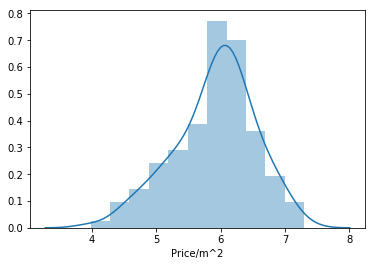

In [269]:
sns.distplot(df_conv_app['Price/m^2'])

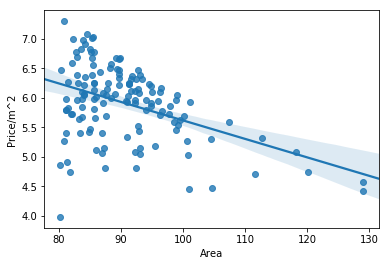

In [270]:
sns.regplot(x='Area', y= 'Price/m^2', data=df_conv_app)

In [271]:
df_conv_app[['Price','Area','Price/m^2','Bedrooms']].corr()

Price      Area  Price/m^2  Bedrooms
Price      1.000000  0.385703   0.654403 -0.090707
Area       0.385703  1.000000  -0.438235  0.332109
Price/m^2  0.654403 -0.438235   1.000000 -0.357889
Bedrooms  -0.090707  0.332109  -0.357889  1.000000

Findings of venues.

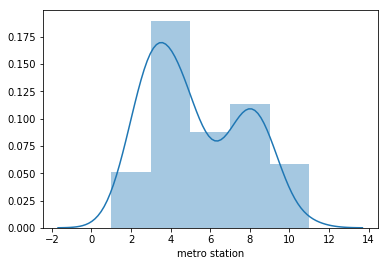

In [272]:
sns.distplot(df_conv_app['metro station'],bins=5)

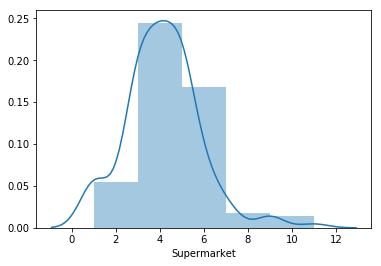

In [273]:
sns.distplot(df_conv_app.Supermarket,bins=5)

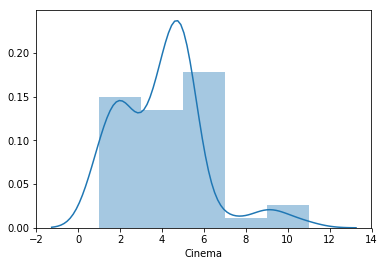

In [274]:
sns.distplot(df_conv_app.Cinema,bins=5)

In [281]:
df_app.corr()

Price  Bedrooms      Area  Longitude  Latitude  \
Price          1.000000  0.014599  0.371372  -0.259604 -0.364579   
Bedrooms       0.014599  1.000000  0.297218  -0.093706  0.196442   
Area           0.371372  0.297218  1.000000   0.004165  0.285056   
Longitude     -0.259604 -0.093706  0.004165   1.000000  0.170943   
Latitude      -0.364579  0.196442  0.285056   0.170943  1.000000   
metro station  0.310152 -0.047573 -0.138345  -0.693293 -0.611075   
Supermarket    0.320443  0.091338 -0.083478  -0.705997 -0.527962   
Cinema         0.260283  0.000539 -0.096259  -0.630626 -0.502420   
Price/m^2      0.635407 -0.241015 -0.473468  -0.251663 -0.566714   

               metro station  Supermarket    Cinema  Price/m^2  
Price               0.310152     0.320443  0.260283   0.635407  
Bedrooms           -0.047573     0.091338  0.000539  -0.241015  
Area               -0.138345    -0.083478 -0.096259  -0.473468  
Longitude          -0.693293    -0.705997 -0.630626  -0.251663  
Latitude           -0.611075    -0.527962 -0.502420  -0.566714  
metro station       1.000000     0.753532  0.683433   0.404896  
Supermarket         0.753532     1.000000  0.609069   0.360947  
Cinema              0.683433     0.609069  1.000000   0.323143  
Price/m^2           0.404896     0.360947  0.323143   1.000000

In [283]:
df_conv_app.head()

Address  Price  Bedrooms   Area   Longitude   Latitude  metro station  \
0      阳明新城  558.0         3  89.79  121.527805  31.275399              7   
1      阳明新城  575.0         3  89.79  121.527805  31.275399              7   
2      阳明新城  568.0         3  89.79  121.527805  31.275399              7   
3      文化名园  570.0         3  92.70  121.498061  31.312913              6   
4  鞍山四村第二小区  550.0         2  87.90  121.514984  31.283729             10   

   Supermarket  Cinema  Price/m^2  
0            7       5   6.214501  
1            7       5   6.403831  
2            7       5   6.325871  
3            9       5   6.148867  
4            6       7   6.257110

Plot those apartments in a map, we find most apartments are in the middle and south of Yangpa Area.

In [318]:
latitude= 31.2920112
longitude= 121.5414305

yangpu = folium.Map(location=[latitude, longitude], zoom_start=12.5)

# add markers to map
for lat, lng, label in zip(df_conv_app['Latitude'], df_conv_app['Longitude'],'￥' + df_conv_app['Price'].astype(str)+ ', '+df_conv_app['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(yangpu)
yangpu

### Clustering

We select price, area, longitude, latitude as clusering features.  
The apartments falls into 3 clusters.  
Cluster 0: low price, small area, with fewer metro stations, supermarkets and cinemas, and low unit price.  
Cluster 1: high price, large area, with many metro stations, supermarkets and cinemas, and medium unit price.  
Cluster 2: medium price, medium area, with enough metro stations, supermarkets and cinemas, and high unit price.

In [305]:
# normalize price, area, lon, lat
scaler = StandardScaler()
X = scaler.fit_transform(df_conv_app.iloc[:,[1,3,4,5]])

array([[ 4.53744996e-01, -9.61004004e-02, -4.89256217e-01,
        -6.19017520e-01],
       [ 7.66122204e-01, -9.61004004e-02, -4.89256217e-01,
        -6.19017520e-01],
       [ 6.37496295e-01, -9.61004004e-02, -4.89256217e-01,
        -6.19017520e-01],
       [ 6.74246554e-01,  2.33950828e-01, -3.11642026e+00,
         1.29093788e+00],
       [ 3.06743957e-01, -3.10463569e-01, -1.62168192e+00,
        -1.94911094e-01],
       [ 3.98619606e-01,  1.57457128e+00,  2.29009584e-01,
        -5.69377212e-01],
       [ 1.04174915e+00,  3.13344595e-01,  2.29009584e-01,
        -5.69377212e-01],
       [ 9.49873503e-01, -7.69813218e-01,  2.29009584e-01,
        -5.69377212e-01],
       [ 2.14868307e-01, -5.94012735e-01, -1.27138161e+00,
        -8.09076258e-01],
       [ 3.06743957e-01,  8.91784892e-01, -9.38834787e-01,
         2.70180406e-01],
       [-6.12012538e-01, -7.82289381e-01,  7.09946409e-02,
        -7.30670028e-01],
       [-5.20136888e-01,  2.69110925e-01,  7.09946409e-02,
      

In [306]:
number_of_clusters = 3
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(X)

In [307]:
kmeans.labels_

array([2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 2, 1, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 0, 1, 0, 0, 0, 1, 1, 0, 2, 2, 0, 0, 2, 1, 1, 2,
       2, 2, 2, 0, 0, 1, 0, 0, 1, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 2, 2, 0,
       2, 0, 0, 0, 2, 2, 2, 0, 1, 1, 2, 2, 0, 2, 2, 1, 0, 0, 0, 0, 1, 0,
       1, 2, 1, 1, 2], dtype=int32)

In [308]:
df_conv_app['Cluster']=kmeans.labels_

/Users/charlottehe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Cluster0 is red, Cluster1 is purple, Cluster2 is green.

In [317]:
latitude= 31.2920112
longitude= 121.5414305

yangpu = folium.Map(location=[latitude, longitude], zoom_start=12.5)

x = np.arange(number_of_clusters)
ys = [i+x+(i*x)**2 for i in range(number_of_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, info, cluster in zip(df_conv_app['Latitude'], df_conv_app['Longitude'],'￥' + (df_conv_app['Price']*10000).astype('int').astype(str)+ ', '+df_conv_app['Area'].astype('str')+', '+df_conv_app['Address']+', '+df_conv_app['metro station'].astype('str')+' metro stations, '+df_conv_app['Supermarket'].astype('str') +' supermarkets, ' , df_conv_app['Cluster']):
    label = folium.Popup(info+ ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(yangpu)

yangpu

In [310]:
df_conv_app.groupby('Cluster').mean()

Price  Bedrooms       Area   Longitude   Latitude  \
Cluster                                                           
0        469.735294  2.500000  86.856471  121.539964  31.311409   
1        567.022727  2.477273  94.818864  121.521307  31.287489   
2        544.796610  2.169492  89.697627  121.538507  31.273863   

         metro station  Supermarket    Cinema  Price/m^2  
Cluster                                                   
0             3.088235     2.676471  2.352941   5.418352  
1             7.181818     5.159091  4.840909   6.050149  
2             5.033898     4.237288  4.237288   6.090598

We find a **cost-effecient** apartment here! A red marker means it is cheap(price and unit price). It is close to cluster1, which means it is as convenient as those apartments of Cluster1. As we compare the area, 82.14 m^2 vs 80.8 m^2. Bravo!

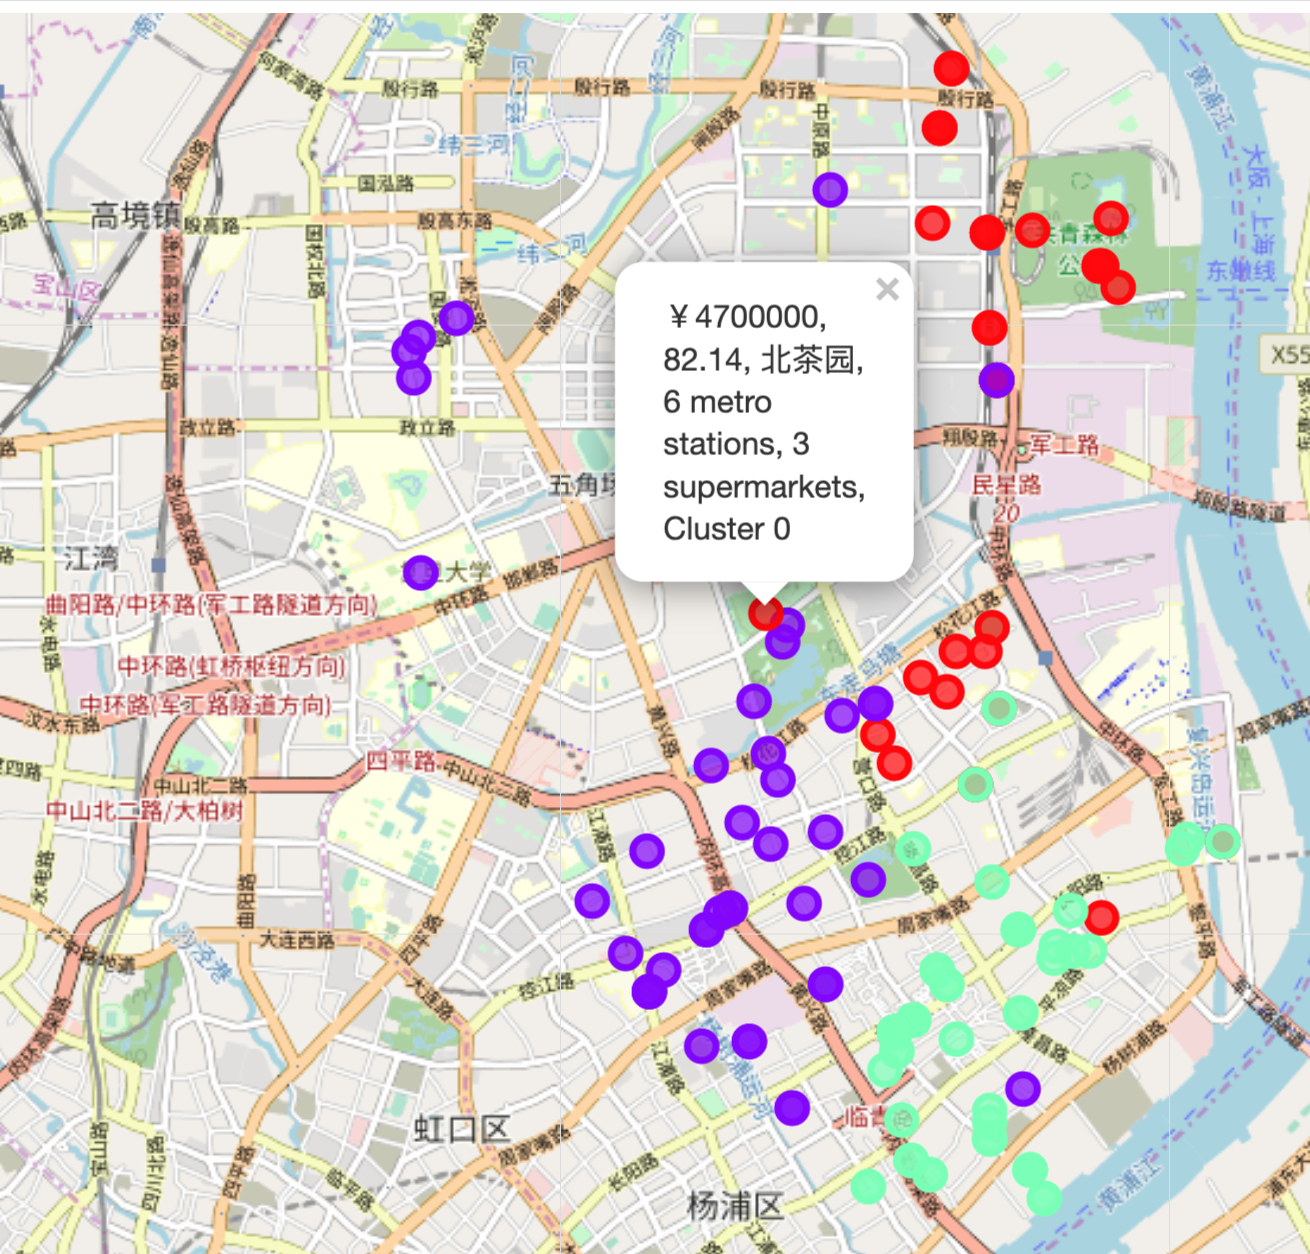

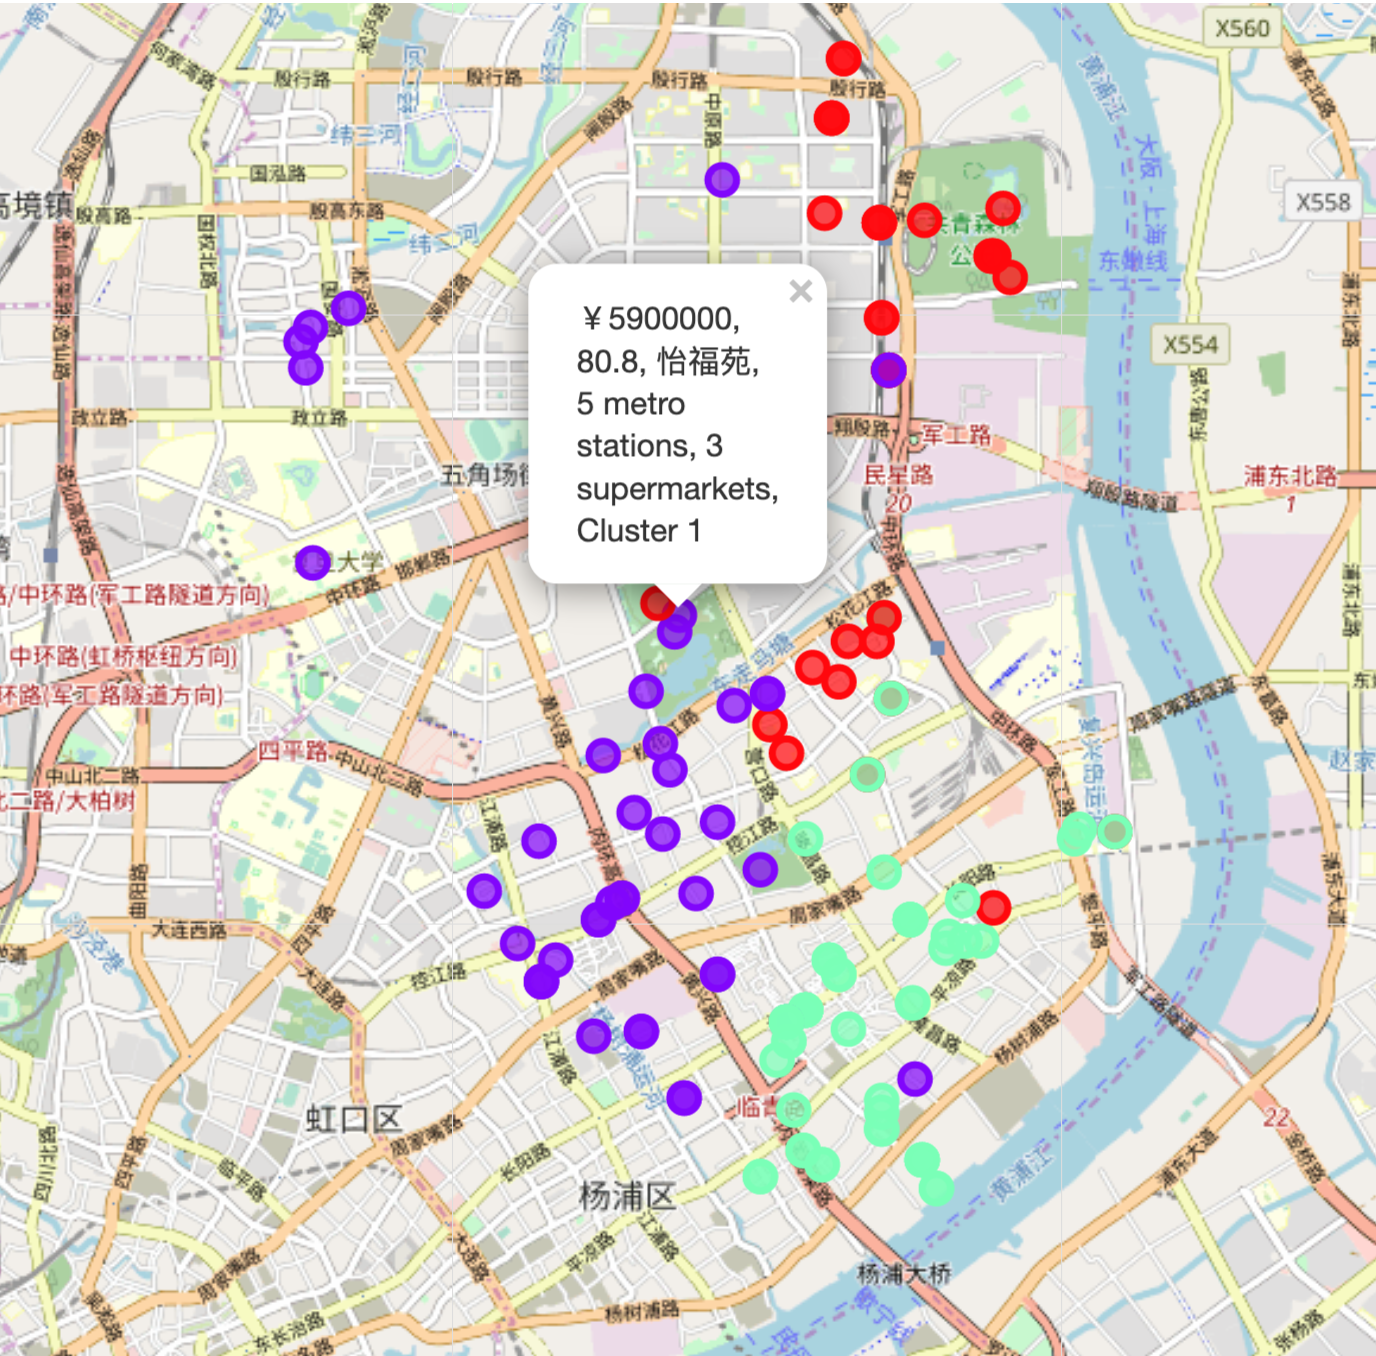

## Conclusion <a name="conclusion"></a>

Purpose of this project was to find an appropriate apartment in Yangpu Area.The apartment has to meet the following 2 conditions:
1. Apartment with min 2 bedrooms and min 80 square meters with price not to exceed 6,000,000RMB
2. Area with ammenities like subway metro station,supermarket and cinemas within walking distance(<=1.5 km)

First,we collect apartment description data from lianjia website, get geodata with Baidu api and use Foursquare api to find venues like metro station,supermarket and cinemas.

Secondly, we explored the information of apartment, such as price, number of bedrooms and area and found that constraint is a common requirement. We also figured out the relationship between price and area. We compared the situation of all apartments in Yangpu Area and the selected convenient apartments. 

Thirdly, we used k-means clustering method to divide them into 3 categories by price, area, location. After that we found features of each cluster as follows:
Cluster 0: low price, small area, with fewer metro stations, supermarkets and cinemas, and low unit price.
Cluster 1: high price, large area, with many metro stations, supermarkets and cinemas, and medium unit price.
Cluster 2: medium price, medium area, with enough metro stations, supermarkets and cinemas, and high unit price.

Finally, we found a **cost efficient** apartment!